# Homework Set 4
### James Graham - N11252710

-------------------------------------------------


The AR(1) process is given by

$$ X_{t+1} = \beta + \alpha X_t + \sigma W_{t+1}, \ \{ W_t \} \sim N(0,1) $$

For simplicity, suppose $\beta = 0$, $\sigma = 1$. Now consider the parameter set: $\alpha \in \{0.5,0.6, 0.7, 0.8, 0.9\}$. We now run a simulation of the AR(1) process for each of $n \in \{ 50,100, 150, ..., 500\}$ observations. 

We then take an OLS estimate of $\alpha$ based on each of these samples. Since we know the value of $\alpha$ in each case, we can compute the bias of the OLS estimate associated with the size of the simulated data sample.

NOTE: The simulations will differ since the pseudo-random number generator for the normally distributed random variable will draw a different seed/simulation each time. Hence, we want to draw each of the $n$ simulations some $M$ number of times and take an average. 

The following cell imports the libraries we'll need, defines the set of $\alpha$ parameters, and the set of observations, $n$. I set $\beta=0$, since it is unused elsewhere, and $M$ sets the number of simulations. 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from scipy.stats import linregress
from numba import jit

a = np.linspace(0.5,0.9,5)
n = np.linspace(50,500,10)
n = n.astype(int)             # convert np.array float-type to int-type
b = 0
M = 10000


The following cell defines two functions: an AR(1) simulation function, and a linear regression coefficient computation functions. Notice that everything is implemented as loops and then compiled via jit. Although looping tends to be slower in general (especially in native Python, as in Matlab), the jit procedure is much, much faster working on loops than it is working on vectorized functions. 

In [14]:
@jit
def ar1_sim(n, b, a, W):
    x = np.empty(n)
    x[0] = 1 
    for t in range(n-1):
        x[t+1] = b + a*x[t] + W[t]
    return x

@jit
def ar1_regress(n, b, a, W):
    x = ar1_sim(n, b, a, W)
    xmean = np.mean(x)
    var_xx = 0
    cov_xx1 =0
    for t in range(n-1):
        var_xx  += (x[t] - xmean)*(x[t] - xmean)
        cov_xx1 += (x[t] - xmean)*(x[t+1] - xmean)
    var_xx = var_xx/(n-1)
    cov_xx1 = cov_xx1/(n-1)
    ahat = cov_xx1/var_xx
    return ahat


Now we implement the loop over the functions that will compute the average OLS coefficients. Note, we loop over true coefficient values, $a$, over sample lengths, $n$, and over simulation numbers, $M$. We take the average over simulations to get a measure of the bias of the OLS procedure. 

In [15]:
%%timeit

bias = np.empty((len(a),len(n)))
                          
for a_i in range(len(a)):
    for n_i in range(len(n)):
        #W = np.empty((n[n_i],M))
        #W = randn(n[n_i],M)
        ahattmp = 0
        #ahat = 0
        
        for m in range(M):
            W = np.empty(n[n_i])
            W = randn(n[n_i])
            ahattmp += ar1_regress(n[n_i], b, a[a_i], W)
        
        ahat = ahattmp/M    
        bias[a_i, n_i] = ahat - a[a_i]
                

-0.0283704608939


We can see that the above code is very quick! Running 10000 simulations per $(a,n)$ pair takes just 13 seconds in total.

Finally, we plot the bias of the OLS esimates of the $\alpha$ coefficient in the AR(1) for each $a$ value across $n$ observations.

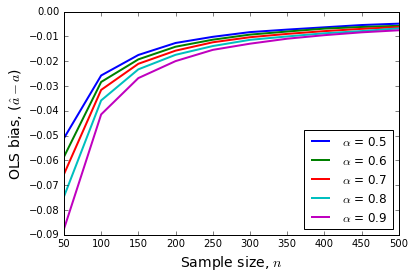

In [18]:
%matplotlib inline

### Plot simulations
fig, ax = plt.subplots()
for a_i in range(len(a)):
        currentlabel = r'$\alpha$ = %0.1f' % a[a_i] 
        ax.plot(n, bias[a_i, :], linewidth = 2, label = currentlabel)
ax.legend(loc = 'lower right')
plt.xlabel('Sample size, $n$', fontsize = 14)
plt.ylabel('OLS bias, ($\hat{a} - a$)', fontsize = 14)
plt.show()

We see that the  bias is worse for larger values of $\alpha$, and for smaller sample sizes, $n$. 